In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2, os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

REBUILD_DATA = False   #Toggle switch to create data

class DogsVCats():  #Data loader
    img_size = 50
    cats = "drive/MyDrive/Colab Notebooks/datasets/PetImages/Cat"
    dogs = "drive/MyDrive/Colab Notebooks/datasets/PetImages/Dog"
    labels = {cats: 0, dogs: 1}

    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):  #Data prep, shuffle and training data creation
        for label in self.labels:
            print(label)
            for image in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, image)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.img_size, self.img_size))
                    self.training_data.append([np.array(img), 
                                              np.eye(2)[self.labels[label]]])
                    
                    if label == self.cats:
                      self.catcount += 1
                    elif label == self.dogs:
                      self.dogcount += 1
                
                except Exception as e:
                    pass
        
        np.random.shuffle(self.training_data)
        np.save("drive/MyDrive/Colab Notebooks/datasets/training_data.npy", self.training_data)
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)

class Net(nn.Module):   #NN Architecture
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #Input, Output, Kernel size
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.fc1 = nn.Linear(128*8*8,512)
        self.fc2 = nn.Linear(512,2)

        #x = torch.randn(50,50).view(-1,1,50,50)
        #self._to_linear = None

    def forward(self, x):
        x = self.conv1(x) #Output is (32 x 46 x 46)
        x = F.relu(x)
        x = self.conv2(x) #Output is (64 x 42 x 42)
        x = F.relu(x)
        x = F.max_pool2d(x,2) #Output is (64 x 21 x 21)
        x = self.conv3(x)     #Output is (128 x 17 x 17)
        x = F.relu(x)
        x = F.max_pool2d(x,2) #Output is (128 x 8 x 8)
        x = torch.flatten(x,1) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1) #Training with Softmax gives an accuracy of 76.3%, whereas log_softmax gets stuck at 50%
        return x

if torch.cuda.is_available():   #Checking GPU or CPU
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

net = Net().to(device)

if REBUILD_DATA:
    dogsvcats = DogsVCats()
    dogsvcats.make_training_data()

training_data = np.load("drive/MyDrive/Colab Notebooks/datasets/training_data.npy", allow_pickle=True)
#print(len(training_data))

optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

Val_Pct = 0.1
val_size = int(len(X)*Val_Pct)
print("Validation test size:", val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("Training Sample Size: ", len(train_X))
print("Testing Sample Size: ",len(test_X))

Running on GPU
Validation test size: 2494
Training Sample Size:  22452
Testing Sample Size:  2494


In [ ]:
def forward_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
        
    return acc, loss

In [ ]:
def test(size=32):
    random_start = np.random.randint(len(test_X)-size)
    X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():  
        val_acc, val_loss = forward_pass(X.view(-1,1,50,50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

0.59375 tensor(0.2471, device='cuda:0')


In [ ]:
import time

Model_Name = f"Model-{int(time.time())}"

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr= 0.001)
loss_function = nn.MSELoss()

print(Model_Name)

def train():
    batch_size = 128
    EPOCHS = 8

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0,len(train_X),batch_size)):
                batch_X = train_X[i: i+batch_size].view(-1,1,50,50).to(device)
                batch_y = train_y[i: i+batch_size].to(device)

                acc, loss = forward_pass(batch_X, batch_y, train=True)
                if i%50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f'{Model_Name}, {round(time.time(),3)},{round(float(acc),2)}, {round(float(loss),4)},{round(float(val_acc),2)}, {round(float(val_loss),4)}\n')

train()


  2%|▏         | 3/176 [00:00<00:07, 21.68it/s]

Model-1606659347


100%|██████████| 176/176 [00:06<00:00, 27.53it/s]


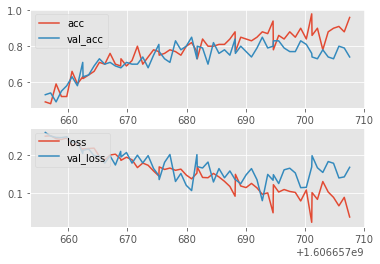

In [3]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

style.use("ggplot")

model_name = "Model-1606657656"
#model_name = "Model-1606659347" #Testing different model logs

def create_acc_loss_graph(model_name):
    contents = open("drive/MyDrive/Colab Notebooks/datasets/model.log", "r").read().split("\n")
    #contents = open("model.log", "r").read().split("\n") #If model is not saved to gdrive

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []
    
    for c in contents:
      if model_name in c:
         name, timestamp, acc, loss, val_acc, val_loss = c.split(',')
         
         times.append(float(timestamp))
         accuracies.append(float(acc))
         losses.append(float(loss))

         val_accs.append(float(val_acc))
         val_losses.append(float(val_loss))

      
      #plt.plot(times, accuracies)
      #plt.show()

    fig = plt.figure() #for multiple figures

    ax1 = plt.subplot2grid((2,1), (0, 0))
    ax2 = plt.subplot2grid((2,1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)

    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)

    plt.show()

      
create_acc_loss_graph(model_name)

# Overfitting

We can clearly see that the training accuracy and validation accuracy is diverging, which is a sign for overfitting. Same is seen for the loss graph too. Hence, training on larger epochs might be a potential solution